<a href="https://colab.research.google.com/github/soyeunju/ESAA/blob/main/25-1/Assignments/0310_Week2_HM_HOM_Ensemble_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7. 앙상블 학습과 랜덤 포레스트

앙상블 학습

앙상블 방법

ex) 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련 ➡️ 모든 개별 트리의 예측을 구하기 ➡️ 가장 많은 선택을 받은 클래스를 예측으로 삼음

### 7.1 투표 기반 분류기
Hard Voting(직접 투표): 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것(다수결)

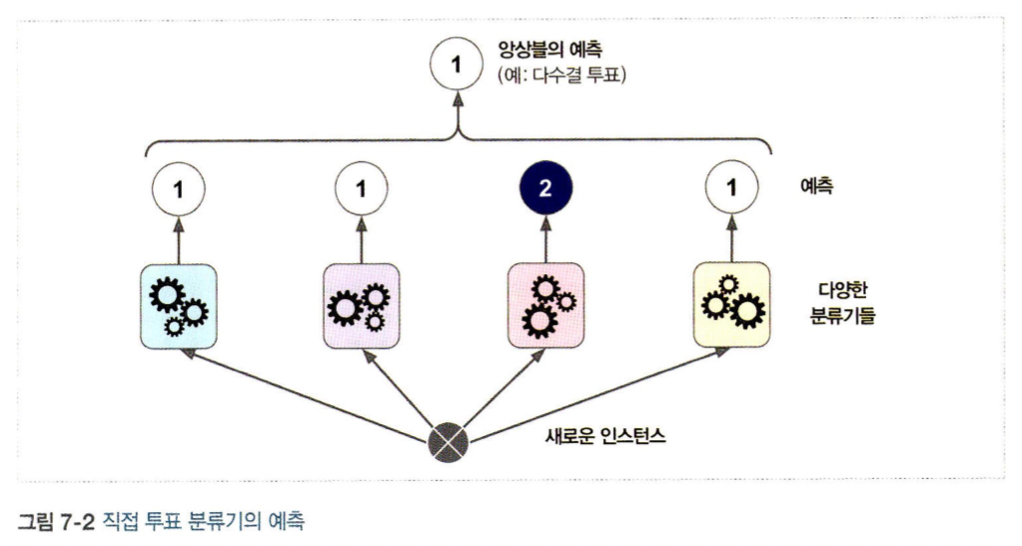

앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음. 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음.(Law of Large Numbers)

앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능 발휘.

각기 다른 알고리즘으로 학습시켜 다양한 분류기를 얻어 다양한 오차 생성 ➡️ 모델 정확도 ⬆️

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

# moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf,voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


Soft Voting(간접 투표): 모든 분류기가 클래스의 확률을 예측할 수 있으면(`predict_proba()`) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음. 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음.

* `voting = 'soft'`
* SVC는 기본적으로 `predict_proba()` 메서드를 제공하지 않으므로 `probability=True`로 설정

### 7.2 배깅과 페이스팅
배깅 : 훈련세트에서 중복을 허용하여 샘플링(bootstrap aggregating의 줄임말)
페이스팅 : 중복을 허용하지 않고 샘플링

배깅과 페이스팅은 같은 훈련 샘플을 여러 번 샘플링 할 수 있음.

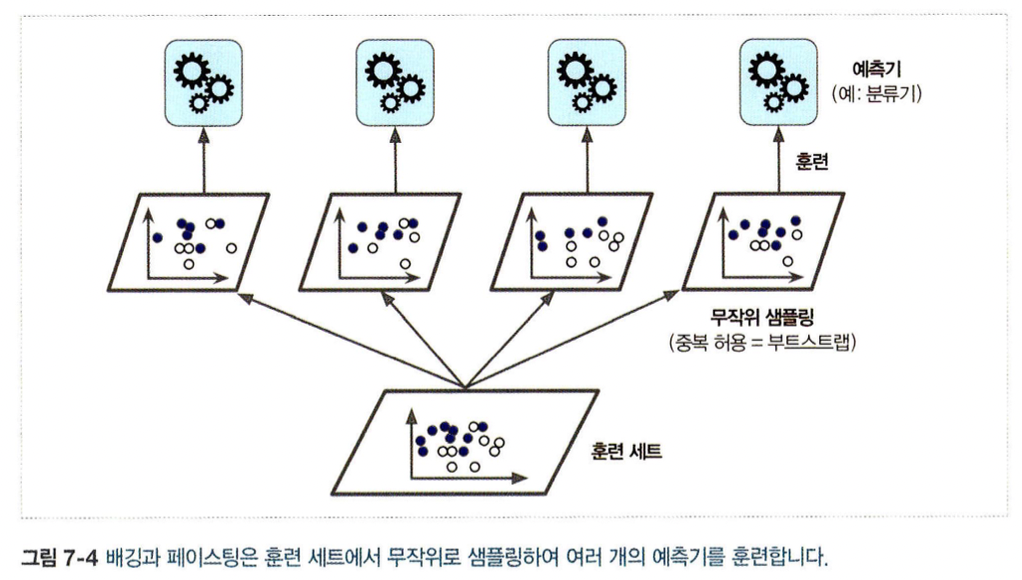


모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦.

수집 함수는 전형적으로 분류일 때는 통계적 최빈값(직접 추표 분류기와 같이) 회귀에 대해서는 평균 계산.

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소.

#### 7.2.1 사이킷런의 배깅과 페이스팅

사이킷런에서는 `BaggingClassifier`, `BaggingRegressor` API 제공.

페이스팅 사용 : `bootstrap = False`

CPU 코어 수 : `n_jobs`, `n_jobs = -1` 모든 코어 사용

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 50, bootstrap = True, n_jobs = -1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

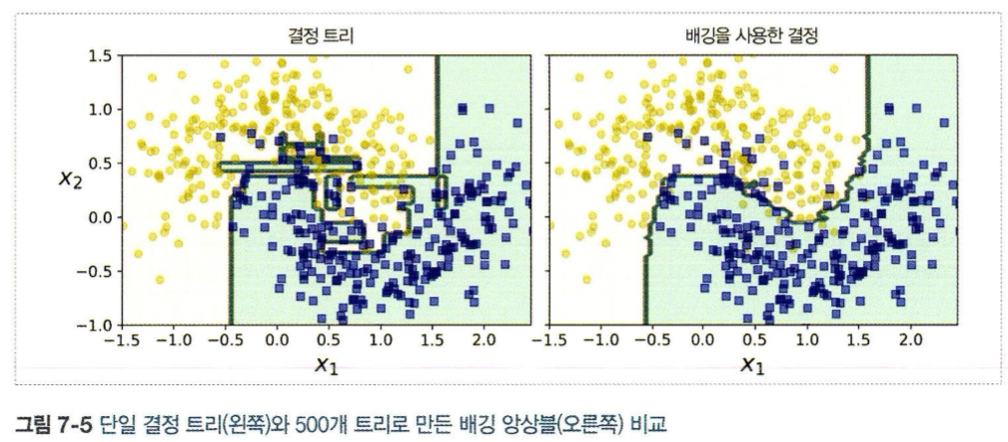

단일 결정 트리와 50개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교

앙상블은 비슷한 편향에서 더 작은 분산을 만듦

부트스래핑

편향 : 배깅 > 페이스팅

다양성 추가 ➡️ 예측기 상관관계 ⬇️ ➡️ 분산 ⬇️에 따라 배깅이 더 나은 모델을 만드는 경우가 많음

#### 7.2.2 obb 평가

`BaggingClassifier`는 기본값으로 중복을 허용하여(bootstrap = True) 훈련 세트의 크기만큼인 m개의 샘플을 선택. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링 된다는 것을 의미 ➡️ 37%를 oob 샘플이라고 부름.

앙상블 평가는 각 예측기의 oob 평가를 평균하여 얻음.(별도의 검증 세트를 사용하지 않음)

사이킷런에서 `BaggingClassifier`를 만들 때 `oob_score = True`로 지정하면 훈련이 끝난 후 자동으로 oob 평가 수행.

결과는 `oob_score_`변수에 저장

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.95

둘이 비슷

oob 샘플에 대한 결정 함수의 값도 `oob_decision_function_`변수에서 확인 가능. 결정 함수는 각 훈련 샘플의 클래스 확률을 반환

In [ ]:
bag_clf.oob_decision_function_

array([[0.08024691, 0.91975309],
       [0.        , 1.        ],
       [0.92655367, 0.07344633],
       [0.92631579, 0.07368421],
       [0.94535519, 0.05464481],
       [0.11042945, 0.88957055],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.01621622, 0.98378378],
       [1.        , 0.        ],
       [0.99450549, 0.00549451],
       [0.        , 1.        ],
       [0.3220339 , 0.6779661 ],
       [0.89071038, 0.10928962],
       [0.        , 1.        ],
       [0.98395722, 0.01604278],
       [0.        , 1.        ],
       [0.00543478, 0.99456522],
       [1.        , 0.        ],
       [0.23655914, 0.76344086],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.53631285, 0.46368715],
       [0.0106383 , 0.9893617 ],
       [0.98876404, 0.01123596],
       [0.64736842, 0.35263158],
       [0.03431373, 0.96568627],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.95939086, 0.04060914],
       [0.

### 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier의 특성 샘플링

특성 샘플링:

`max_features`와 `bootstrap_features` 매개변수로 조절.
각 예측기는 무작위로 선택된 입력 특성의 일부로 훈련됨.

* 랜덤 패치 방식 (Random Patches Method): 훈련 샘플과 특성 모두 샘플링.
고차원 데이터(예: 이미지)에 유용.

* 랜덤 서브스페이스 방식 (Random Subspaces Method): 훈련 샘플은 모두 사용하고, 특성만 샘플링. 편향 증가, 분산 감소.

### 7.4 랜덤 포레스트
랜덤 포레스트는 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블. `max_samples`를 훈련 세트의 크기로 지정. `BaggingClassifier`에 `DecisionTreeClassifier`를 넣어 만드는 대신 `RandomForestClassifier`를 사용.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 주입. ➡️ 트리를 다양하게 만들고 ➡️ 편향⬆️, 분산⬇️

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

극단적으로 무작위한 트리의 랜덤 포레스트를 익스트럼 랜덤 트리 앙상블이라고 부름. 랜덤 포레스트보다 더 무작위한 트리 생성

각 노드에서 특성의 서브셋을 무작위 선택
최적의 임곗값을 찾는 대신 임곗값도 무작위 선택 후 최적의 분할 결정

랜덤 포레스트보다 더 낮은 분산(Variance)
더 빠른 학습 속도 (임곗값 최적화 과정 생략)
사용법

`ExtraTreesClassifier` : 분류
`ExtraTreesRegressor` : 회귀

RandomForestClassifier와 동일한 API 사용

편향(Bias)은 증가하지만, 분산을 낮춰 더 안정적인 모델을 만듦.

### 7.4.2 특성 중요도
사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정. 가중치 평균 사용.
사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값 정규화. `feature_importances_`

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09921004666783378
sepal width (cm) 0.021130128146925657
petal length (cm) 0.4348722863433751
petal width (cm) 0.4447875388418654
